In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import copy

from rembg import remove

import open3d as o3d
from open3d.visualization import draw_geometries

from process_bag import get_images
from utils import get_o3d_intrinsics, colordepth_to_rgbd, rgbd_to_pcd, remove_outliers
from utils import finetune_corners, gen_cameras, gen_pcds, align_pcds
from utils import show_imgs, draw_axis, read_colmap_array

depth_intrinsics, color_intrinsics = get_o3d_intrinsics()

In [215]:
# Chessboard size
cb_counts = (4, 7)
cb_scale = 2
cb_size = 0.033 * cb_scale

# Rendering settings
voxel_size = 0.02
camera_size = 2 * cb_size
# origin_size = 4 * cb_size
origin_size = 1

kwargs = dict(
    zoom=0.5,
    front=[0.0, 0.0, -1.0],
    lookat=[0.0, 0.0, 0.0],
    up=[1.0, 0, 0],
)
kwargs = dict(
    zoom=1.0,
    front=[0.0, 0.0, -1.0],
    lookat=[0.0, 0.0, 0.0],
    up=[0, 1.0, 0],
)

# data_name = "books_2"
data_name = "bear"

data_name_raw = data_name.split("_")[0]
data_folder = f"data/{data_name}"

# mkdir imgs, npys, plys, plys_final
for folder in ["imgs", "npys", "plys", "plys_final"]:
    os.makedirs(os.path.join(data_folder, folder), exist_ok=True)

color_fp = os.path.join(data_folder, "npys/color.npy")
depth_fp = os.path.join(data_folder, "npys/depth.npy")
color_single_fp = os.path.join(data_folder, "npys/color_single.npy")
depth_single_fp = os.path.join(data_folder, "npys/depth_single.npy")

In [ ]:
# Setup origin
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=origin_size, origin=[0,0,0])
origin2 = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=origin_size, origin=[0,0,0])
origin2.rotate(R=np.array([[-1,0,0],[0,-1,0],[0,0,-1]]), center=[0,0,0])
origin2.paint_uniform_color([0,1,1])

origin_both = o3d.geometry.TriangleMesh()
origin_both += origin
origin_both += origin2

### Read BAGs

In [216]:
# Load/Process Data
def get_imgs(color_fp, depth_fp, start_idx, end_idx, align=True):
    if os.path.exists(color_fp) and os.path.exists(depth_fp):
        color_imgs = np.load(color_fp)
        depth_imgs = np.load(depth_fp)
    else:
        color_imgs = []
        depth_imgs = []
        fps = sorted(glob.glob(f'{data_folder}/bags/*.bag'))
        for i, fp in enumerate(fps):
            if not os.path.exists(fp):
                continue
            if i % 10 == 0:
                print(f"Processing bag {i+1}/{len(fps)} {fp}")
            color_img, depth_img = get_images(
                start_idx=start_idx,
                end_idx=end_idx,
                bag_fp=fp,
                align=align,
                median=True
            )
            color_imgs.append(color_img)
            depth_imgs.append(depth_img)
        color_imgs = np.stack(color_imgs)
        depth_imgs = np.stack(depth_imgs)
        np.save(color_fp, color_imgs)
        np.save(depth_fp, depth_imgs)
    
    # Depth to meters
    depth_imgs = depth_imgs.astype(np.float32) / 1000.0
    return color_imgs, depth_imgs

color_imgs, depth_imgs = get_imgs(color_fp, depth_fp, 0, 30)
color_imgs_single, depth_imgs_single = get_imgs(
    color_single_fp, depth_single_fp, 5, 6)

color_imgs.shape, depth_imgs.shape, color_imgs_single.shape, depth_imgs_single.shape

((211, 480, 640, 3), (211, 480, 640), (211, 480, 640, 3), (211, 480, 640))

In [217]:
# Remove background
save_dir = os.path.join(data_folder, "npys/color_nobg.npy")

if not os.path.exists(save_dir):
    color_imgs_nobg = []
    for i in tqdm(range(len(color_imgs))):
        color_img = color_imgs[i]
        color_img_nobg = remove(color_img)
        color_imgs_nobg.append(color_img_nobg)
    color_imgs_nobg = np.stack(color_imgs_nobg)
    np.save(save_dir, color_imgs_nobg)
else:
    color_imgs_nobg = np.load(save_dir)
color_imgs_nobg.shape

(211, 480, 640, 4)

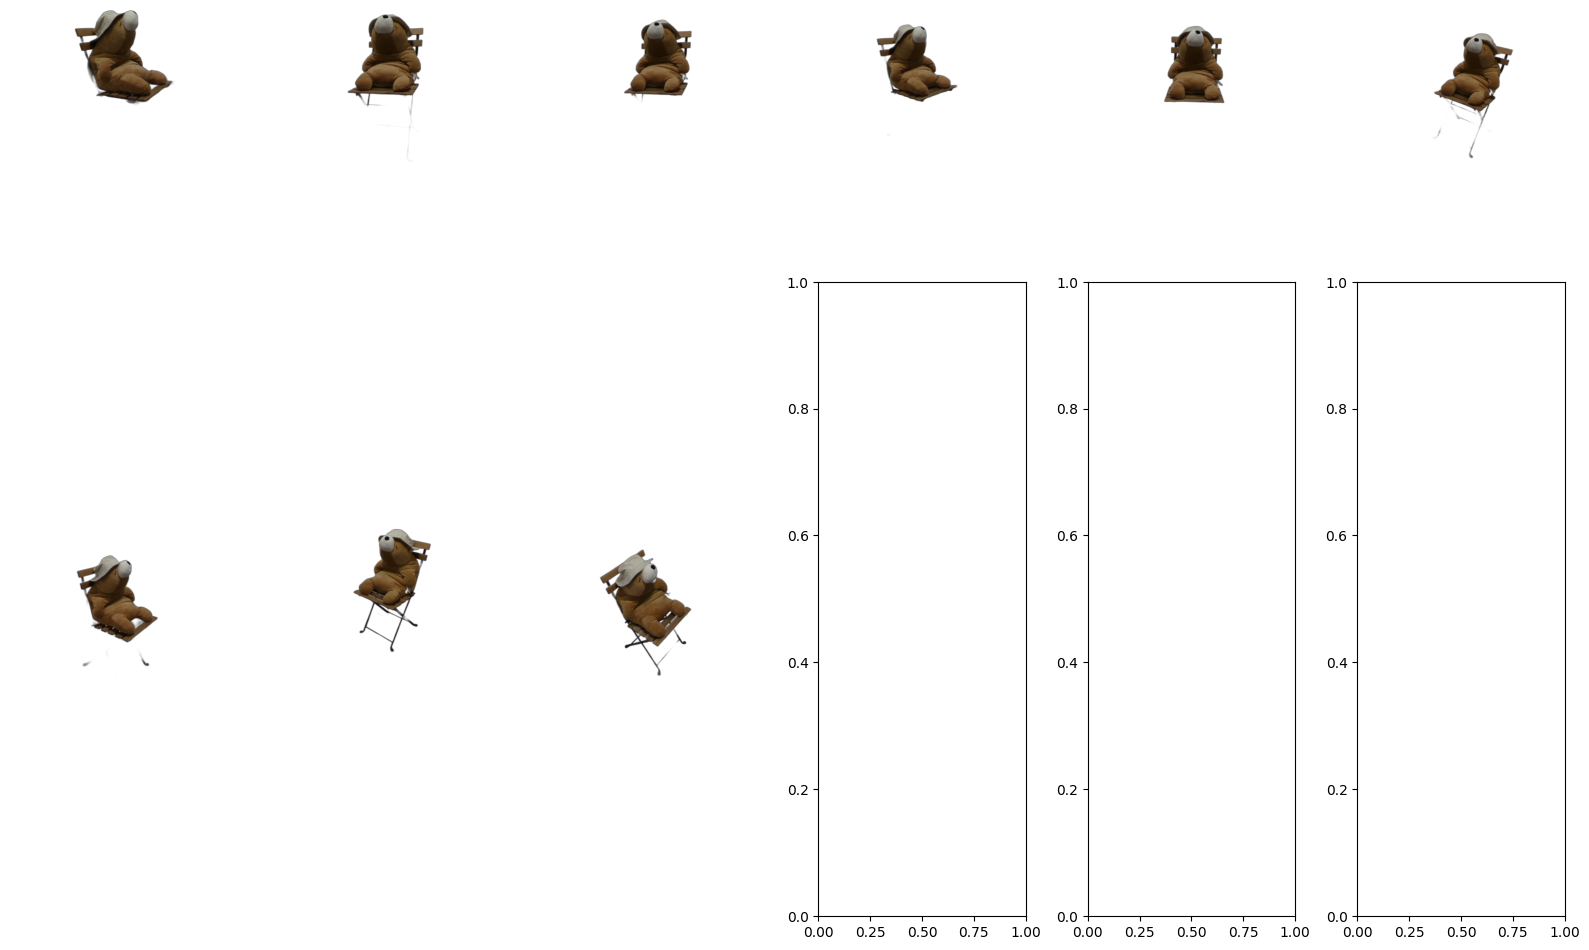

In [220]:
show_imgs(color_imgs_nobg[::24], width=6)

In [223]:
# Save images for colmap
colmap = True
fps = []

save_dir = os.path.join(data_folder, "imgs")
for i in tqdm(range(len(color_imgs_nobg))):
    fp = os.path.join(save_dir, f"color_{i}.png")
    fps.append(fp)
    if os.path.exists(fp):
        continue
    img = color_imgs_nobg[i].copy()
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGRA)
    cv2.imwrite(fp, img)

100%|██████████| 211/211 [00:00<00:00, 201090.24it/s]


### COLMAP

In [ ]:
# Read cameras.txt
colmap_folder = os.path.join(data_folder, "sparse/0")
cameras_fp = os.path.join(colmap_folder, "cameras.txt")
images_fp = os.path.join(colmap_folder, "images.txt")

cameras_lines = []
images_lines = []
with open(cameras_fp, "r") as f:
    cameras_lines = [l.strip() for l in f.readlines() if l[0] != "#"]
with open(images_fp, "r") as f:
    images_lines = [l.strip() for l in f.readlines() if l[0] != "#"]

In [ ]:
_, _, w, h, focal, ppx, ppy, dist_k = cameras_lines[0].strip().split(" ")
w, h, focal, ppx, ppy, dist_k = int(w), int(h), float(focal), float(ppx), float(ppy), float(dist_k)
intrinsics = o3d.camera.PinholeCameraIntrinsic(w, h, focal, focal, ppx, ppy)

print(f"Camera: {w}x{h}")
print(f"dist_k: {dist_k}")
print(f"Camera intrinsics:\n{intrinsics.intrinsic_matrix}")
print(f"Color intrinsics:\n{color_intrinsics.intrinsic_matrix}")

In [ ]:
from scipy.spatial.transform import Rotation as R

# IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME
pose_lines = [l for l in images_lines if l.endswith(".png")]
pose_lines = [l.split(" ") for l in pose_lines]

colmap_data = {}
for pose_line in pose_lines:
    # Quaternion and translation
    _, qw, qx, qy, qz, tx, ty, tz, _, name = pose_line
    qw, qx, qy, qz, tx, ty, tz = float(qw), float(qx), float(qy), float(qz), float(tx), float(ty), float(tz)

    # Convert to rotation matrix
    r = R.from_quat([qx, qy, qz, qw])
    rot_mat = r.as_matrix()
    t = np.array([tx, ty, tz])

    # Convert to extrinsics matrix (4x4)
    c2w = np.eye(4)
    c2w[:3, :3] = rot_mat
    c2w[:3, 3] = t

    # Convert to camera-to-world matrix (4x4)
    c2w = np.linalg.inv(c2w)
    colmap_data[name] = {
        "c2w": c2w,
    }

len(colmap_data), list(colmap_data.keys())[:5]

In [ ]:
# Read images
images_folder = os.path.join(data_folder, "dense/0/images")
depth_map_folder = os.path.join(data_folder, "dense/0/stereo/depth_maps")

geo_count, photo_count = 0, 0
for file_name in colmap_data.keys():
    color = cv2.imread(os.path.join(images_folder, file_name))
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    colmap_data[file_name]["color"] = color

    # Load Depth Maps
    geo_fp = os.path.join(depth_map_folder, f"{file_name}.geometric.bin")
    photo_fp = os.path.join(depth_map_folder, f"{file_name}.photometric.bin")
    if os.path.exists(geo_fp):
        colmap_data[file_name]["geo_depth"] = read_colmap_array(geo_fp)
        geo_count += 1
    if os.path.exists(photo_fp):
        colmap_data[file_name]["photo_depth"] = read_colmap_array(photo_fp)
        photo_count += 1

print(f"Geometric depth maps: {geo_count}")
print(f"Photometric depth maps: {photo_count}")

In [ ]:
colmap_color = []
colmap_depth = []
colmap_c2w = []
for k in sorted(colmap_data.keys()):
    colmap_color.append(colmap_data[k]["color"])
    colmap_depth.append(colmap_data[k]["photo_depth"])
    colmap_c2w.append(colmap_data[k]["c2w"])

colmap_color = np.stack(colmap_color)
colmap_depth = np.stack(colmap_depth)
colmap_c2w = np.stack(colmap_c2w)

colmap_color.shape, colmap_depth.shape, colmap_c2w.shape

In [224]:
sorted(colmap_data.keys())

['color_0.png',
 'color_1.png',
 'color_10.png',
 'color_100.png',
 'color_101.png',
 'color_102.png',
 'color_103.png',
 'color_104.png',
 'color_105.png',
 'color_106.png',
 'color_107.png',
 'color_108.png',
 'color_109.png',
 'color_11.png',
 'color_110.png',
 'color_111.png',
 'color_112.png',
 'color_113.png',
 'color_114.png',
 'color_115.png',
 'color_116.png',
 'color_117.png',
 'color_118.png',
 'color_119.png',
 'color_12.png',
 'color_120.png',
 'color_121.png',
 'color_122.png',
 'color_123.png',
 'color_124.png',
 'color_125.png',
 'color_126.png',
 'color_127.png',
 'color_128.png',
 'color_129.png',
 'color_13.png',
 'color_130.png',
 'color_131.png',
 'color_132.png',
 'color_133.png',
 'color_134.png',
 'color_135.png',
 'color_136.png',
 'color_137.png',
 'color_138.png',
 'color_139.png',
 'color_14.png',
 'color_140.png',
 'color_141.png',
 'color_142.png',
 'color_143.png',
 'color_144.png',
 'color_145.png',
 'color_146.png',
 'color_147.png',
 'color_148.png',
 

In [ ]:
# Reload imported modules
import importlib
import utils

importlib.reload(utils)

from utils import *

In [ ]:
# Load fused
fused_fp = os.path.join(data_folder, "dense/0/fused.ply")
fused = o3d.io.read_point_cloud(fused_fp)
fused = o3d.geometry.PointCloud.voxel_down_sample(fused, voxel_size=0.04)
fused

In [ ]:
# Cameras
cameras_colmap = gen_cameras(colmap_c2w, camera_size)
draw_geometries([origin_both] + cameras_colmap + [fused])

In [ ]:
colmap_pcds = gen_pcds(colmap_color, colmap_depth, intrinsics, cb_scale=1.0, depth_scale=1.0)
colmap_pcds_align = align_pcds(colmap_pcds, colmap_c2w, voxel_size=0.04)
colmap_pcds_align[:10]

In [ ]:
# Clean up outliers
for i in range(len(colmap_pcds_align)):
    colmap_pcds_align[i] = remove_outliers(
        colmap_pcds_align[i],
        nb_neighbors=50,
        std_ratio=0.5,
    )
colmap_pcds_align[:10]

In [ ]:
draw_geometries([origin_both] + cameras_colmap + colmap_pcds_align,
    zoom=0.5, front=[0, 0, -1], lookat=[0, 0, 0], up=[0, -1, 0])

In [ ]:
# fuse and paint green
fused_colmap = o3d.geometry.PointCloud()
for pcd in colmap_pcds_align:
    fused_colmap += pcd

fused_colmap.paint_uniform_color([0, 1, 0])
fused_colmap = o3d.geometry.PointCloud.voxel_down_sample(fused_colmap, voxel_size=0.04)

# color fused
fused.paint_uniform_color([1, 0, 0])

fused_colmap

In [ ]:
draw_geometries([origin_both, fused, fused_colmap] + cameras_colmap,
    zoom=0.5, front=[0, 0, -1], lookat=[0, 0, 0], up=[0, -1, 0])

In [ ]:
_, h, w = depth_imgs.shape

scan_depths = []
colmap_depths = []
valid_fracs = []

for idx in range(len(depth_imgs)):
    # Scanned depth map
    scan_depth = depth_imgs[idx].copy()

    # Colmap depth map
    file_name = f"color_{idx}.png"
    colmap_depth = colmap_data[file_name]["photo_depth"]
    # Resize to match scan depth map
    colmap_depth = cv2.resize(colmap_depth, (w, h), interpolation=cv2.INTER_NEAREST)

    # Alpha mask
    msk = color_imgs_nobg[idx][:, :, 3].copy() / 255.0
    # Mask all pixels with depth > 0
    msk *= (colmap_depth > 0) & (scan_depth > 0)

    scan_depths.append(scan_depth * msk)
    colmap_depths.append(colmap_depth * msk)
    valid_fracs.append(msk.sum() / msk.size)

scan_depths = np.stack(scan_depths)
colmap_depths = np.stack(colmap_depths)
valid_fracs = np.stack(valid_fracs)

scan_depths.shape, colmap_depths.shape, valid_fracs.shape

In [ ]:
# Use torch and optimize for multiplier scale
import torch

def find_scale(mat1, mat2, weights):
    mat1 = torch.from_numpy(mat1).float()
    mat2 = torch.from_numpy(mat2).float()
    weights = torch.from_numpy(weights).float()[:, None, None]

    # Optimize scale
    scale = torch.ones(1)
    scale.requires_grad = True

    optimizer = torch.optim.SGD([scale], lr=0.01, momentum=0.8)

    epochs = 120
    for i in range(epochs):
        optimizer.zero_grad()
        loss = torch.mean(weights * torch.pow(mat1 - scale * mat2, 2))
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f"Loss: {loss.item():.6f}")

    scale = scale.detach().numpy()[0]
    print(f"Scale: {scale:.4f}")
    return scale

In [ ]:
# Back to numpy
scale = find_scale(scan_depths, colmap_depths, valid_fracs)

print(f"Initial norm: {np.linalg.norm(scan_depths - colmap_depths):.4f}")
colmap_depths = colmap_depths * scale
print(f"Final norm: {np.linalg.norm(scan_depths - colmap_depths):.4f}")

In [ ]:
# Draw fused and cameras
fused = o3d.io.read_point_cloud(fused_fp)
fused = o3d.geometry.PointCloud.voxel_down_sample(fused, voxel_size=0.04)

camera_size = 0.5
cameras_colmap = gen_cameras(colmap_c2w, camera_size)
draw_geometries([origin_both] + cameras_colmap + [fused])

In [ ]:
# Scale the fused point cloud and colmap_c2w
fused_scaled = copy.deepcopy(fused)
fused_scaled.scale(scale, center=[0, 0, 0])

colmap_c2w_scaled = copy.deepcopy(colmap_c2w)
colmap_c2w_scaled[:, :3, 3] *= scale

# Draw
cameras_colmap_scaled = gen_cameras(colmap_c2w_scaled, camera_size * scale)
origin_s = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5 * scale)
draw_geometries([origin_s] + cameras_colmap_scaled + [fused_scaled])

In [203]:
# Check that projection still works
colmap_pcds_scaled = gen_pcds(colmap_color, colmap_depth, intrinsics, cb_scale=scale, depth_scale=1.0)
colmap_pcds_scaled_align = align_pcds(colmap_pcds_scaled, colmap_c2w_scaled, voxel_size=0.04)

# Clean up outliers
for i in range(len(colmap_pcds_scaled_align)):
    colmap_pcds_scaled_align[i] = remove_outliers(
        colmap_pcds_scaled_align[i],
        nb_neighbors=100,
        std_ratio=0.05,
    )

In [204]:
draw_geometries([origin_s] + cameras_colmap_scaled + colmap_pcds_scaled_align)

In [205]:
# Color fused and draw all
fused_scaled.paint_uniform_color([0, 1, 0])
draw_geometries([origin_s, fused_scaled] + cameras_colmap_scaled + colmap_pcds_scaled_align)

In [206]:
# Project scanned data
scan_pcds = gen_pcds(color_imgs, depth_imgs, color_intrinsics, cb_scale=1.0, depth_scale=1.0)

In [207]:
draw_geometries([origin_s] + scan_pcds)

In [213]:

scan_pcds_align = align_pcds(scan_pcds, colmap_c2w_scaled, voxel_size=0.01)

In [214]:
draw_geometries([origin_s] + scan_pcds_align[::30])

In [201]:
# Clean up outliers
for i in range(len(scan_pcds_align)):
    scan_pcds_align[i] = remove_outliers(
        scan_pcds_align[i],
        nb_neighbors=100,
        std_ratio=0.05,
    )

In [202]:
draw_geometries([origin_s, fused_scaled] + cameras_colmap_scaled + scan_pcds_align)

In [ ]:
# Save the pointclouds and extrinsics
for i, pcd in enumerate(colmap_pcds_scaled):
    fp = f"{data_folder}/plys/pcd_{i:03}.ply"
    o3d.io.write_point_cloud(fp, pcd)

np.save(f"{data_folder}/npys/c2w_extrinsics.npy", colmap_c2w_scaled)

### Pose Estimation

In [ ]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 
    100, 0.01)

# Define object points
objp = np.zeros((cb_counts[0]*cb_counts[1],3), np.float32)
objp[:,:2] = np.mgrid[0:cb_counts[0],0:cb_counts[1]].T.reshape(-1,2)
objp *= cb_size

In [ ]:
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
used_idxs = [] # Indices of images used
for i in tqdm(range(color_imgs.shape[0])):
    gray = cv2.cvtColor(color_imgs[i], cv2.COLOR_RGB2GRAY)
    gray_single = cv2.cvtColor(color_imgs_single[i], cv2.COLOR_RGB2GRAY)

    # Find and refine corners
    flags = cv2.CALIB_CB_EXHAUSTIVE + cv2.CALIB_CB_NORMALIZE_IMAGE
    ret, corners = cv2.findChessboardCornersSB(gray_single, cb_counts, flags=flags)
    if ret == False:
        ret, corners = cv2.findChessboardCornersSB(gray, cb_counts, flags=flags)
    if ret == True:
        corners, flip = finetune_corners(gray, corners, criteria)
        if not flip:
            print("Flipped", i)
        used_idxs.append(i)
        objpoints.append(objp)
        imgpoints.append(corners)

In [ ]:
n = len(used_idxs)
print(f"Found {n} images with checkerboard corners")

In [ ]:
color_imgs = color_imgs[used_idxs]
depth_imgs = depth_imgs[used_idxs]
color_imgs_single = color_imgs_single[used_idxs]
depth_imgs_single = depth_imgs_single[used_idxs]

# Update npy files
np.save(color_fp, color_imgs)
np.save(depth_fp, depth_imgs)
np.save(color_single_fp, color_imgs_single)
np.save(depth_single_fp, depth_imgs_single)

color_imgs.shape, depth_imgs.shape

In [ ]:
# Plot corners
plot_data = []
for i in range(n):
    try:
        img_tmp = cv2.drawChessboardCorners(
            color_imgs[i].copy(), cb_counts, imgpoints[i], True)
        
        # Calculate reprojection error
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
            [objpoints[i]], [imgpoints[i]], img_tmp.shape[:-1][::-1], None, None)
        mat_err = np.linalg.norm(mtx - color_intrinsics.intrinsic_matrix)
        title = f"Image {i} {mat_err:.2f}"
        plot_data.append((mat_err, img_tmp, title, i))
    except Exception as e:
        print(e)
        continue

In [ ]:
# Sort by error and take top k
k = 10
plot_data.sort(key=lambda x: x[0], reverse=True)
plot_filt = plot_data[:k]
plot_imgs = [x[1] for x in plot_filt]
plot_titles = [x[2] for x in plot_filt]
plot_idxs = [x[3] for x in plot_filt]
show_imgs(plot_imgs, plot_titles)

In [ ]:
h, w, _ = color_imgs[0].shape
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, (w, h), None, None)

estimated_intrinsics = o3d.camera.PinholeCameraIntrinsic()
estimated_intrinsics.intrinsic_matrix = mtx

print(color_intrinsics.intrinsic_matrix)
print()
print(estimated_intrinsics.intrinsic_matrix)
dist

In [ ]:
# Note the negative z axis
axis = np.float32([[1,0,0], [0,1,0], [0,0,-1]]).reshape(-1,3) * cb_size * 4

rvecs_lst = []
tvecs_lst = []
plot_coords = []
for i in plot_idxs:
    try:
        img_tmp = color_imgs[i].copy()

        # Find the rotation and translation vectors.
        rvec = rvecs[i].copy()
        tvec = tvecs[i].copy()
        retval, rvec, tvec = cv2.solvePnP(
            objp, imgpoints[i], mtx, dist, 
            rvec=rvec, 
            tvec=tvec,
            useExtrinsicGuess=True,
        )

        # project 3D points to image plane
        imgpts, _ = cv2.projectPoints(axis, rvec, tvec, mtx, dist)
        img_tmp = draw_axis(img_tmp, imgpoints[i], imgpts)
        plot_coords.append(img_tmp)

        rvecs_lst.append(rvec)
        tvecs_lst.append(tvec)
    except Exception as e:
        print(e)
        continue

In [ ]:
show_imgs(plot_coords, plot_titles)

In [ ]:
# Turn lists into extrinsic parameters
rvecs = np.array(rvecs)
tvecs = np.array(tvecs)

# Turn into 4x4 extrinsic matrices
w2c_exts = np.zeros((len(rvecs), 4, 4))
c2w_exts = np.zeros((len(rvecs), 4, 4))
for i in range(len(rvecs)):
    R, _ = cv2.Rodrigues(rvecs[i])
    w2c_exts[i, :3, :3] = R
    w2c_exts[i, :3, 3] = tvecs[i].T
    w2c_exts[i, 3, 3] = 1

    # world to camera -> camera to world
    c2w_exts[i] = np.linalg.inv(w2c_exts[i])
c2w_exts.shape

In [ ]:
# Setup cameras and pcds
cameras = gen_cameras(c2w_exts, camera_size)

intrinsics = color_intrinsics
# intrinsics = estimated_intrinsics
pcds_full = gen_pcds(color_imgs, depth_imgs, intrinsics, cb_scale=cb_scale)
pcds_align = align_pcds(pcds_full, c2w_exts, voxel_size=voxel_size)

In [ ]:
draw_geometries(
    pcds_align + [origin_both] + cameras,
    **kwargs
)

In [ ]:
draw_geometries(
    [origin_both] + cameras, 
    **kwargs
)

In [ ]:
# Save the pointclouds and extrinsics
for i, pcd in enumerate(pcds_full):
    fp = f"{data_folder}/plys/pcd_{i:03}.ply"
    o3d.io.write_point_cloud(fp, pcd)

np.save(f"{data_folder}/npys/c2w_extrinsics.npy", c2w_exts)
np.save(f"{data_folder}/npys/rvecs.npy", rvecs)
np.save(f"{data_folder}/npys/tvecs.npy", tvecs)

### Denoise Pointclouds

In [189]:
pcd_fps = sorted(glob.glob(f"{data_folder}/plys/pcd_*.ply"))

# Seed and split into train, val, test
np.random.seed(0)
n = len(pcd_fps)
idxs = np.arange(n)
np.random.shuffle(idxs)

train_percent, val_percent, test_percent = 0.6, 0.2, 0.2
train_idxs = idxs[:int(n*train_percent)]
val_idxs = idxs[int(n*train_percent):int(n*(train_percent+val_percent))]
test_idxs = idxs[int(n*(train_percent+val_percent)):]

In [191]:
# Load extrinsics
c2w_exts = np.load(f"{data_folder}/npys/c2w_extrinsics.npy")

# Load the pointclouds and align
pcds_full = []
for i, fp in enumerate(pcd_fps):
    pcd = o3d.io.read_point_cloud(fp)
    pcds_full.append(pcd)

In [193]:
draw_geometries(
    align_pcds(pcds_full, c2w_exts, voxel_size=voxel_size))

In [ ]:
# nb_neighbors = 20
# std_ratio = 0.25
# nb_points = 25
# radius = 0.2

# voxel_size = 0.02

# def clean_pcds(pcds_full, c2w_exts, voxel_size=None):
#     pcds_clean = []
#     for i in tqdm(range(len(pcds_full))):
#         clean = pcds_full[i]
#         if voxel_size is not None:
#             clean = clean.voxel_down_sample(voxel_size=voxel_size)
        
#         clean = remove_outliers(
#             clean,
#             nb_neighbors=nb_neighbors,
#             std_ratio=std_ratio,
#             nb_points=nb_points,
#             radius=radius
#         )
#         clean.transform(c2w_exts[i])
#         pcds_clean.append(clean)        
#     return pcds_clean

# pcds_clean_train = clean_pcds(pcds_train, c2w_exts_train, voxel_size=voxel_size)
# pcds_clean_val = clean_pcds(pcds_val, c2w_exts_val, voxel_size=voxel_size)
# pcds_clean_test = clean_pcds(pcds_test, c2w_exts_test, voxel_size=voxel_size)

In [ ]:
# clean = pcds_train[0]
# print(clean)

# nb_neighbors = 20
# std_ratio = 0.25
# nb_points = 25
# radius = 0.15

# voxel_size = 0.045

# # Downsample
# clean = clean.voxel_down_sample(voxel_size=voxel_size)

# clean = remove_outliers(
#     clean,
#     nb_neighbors=nb_neighbors,
#     std_ratio=std_ratio,
#     nb_points=nb_points,
#     radius=radius
# )
# clean
# draw_geometries([clean])

### Crop Pointclouds

In [ ]:
o3d_vis(pcds_full, c2w_exts, align=True)

In [ ]:
# Define crop bounds
# end_1 = np.array([0.04, -0.62, -0.55]) * cb_scale
# end_2 = np.array([1.3, 0.5, 0.35]) * cb_scale

# end_1 = np.array([0.2, -0.1, -0.15]) * cb_scale
# end_2 = np.array([0.65, 0.4, 0.2]) * cb_scale

end_1 = np.array([-0.2, -0.1, -0.15]) * cb_scale
end_2 = np.array([0.65, 0.4, 0.2]) * cb_scale

coord_1 = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.5, origin=[0,0,0])
coord_2 = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.5, origin=[0,0,0])
coord_1.translate(end_1)
coord_2.translate(end_2)

bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=end_1, max_bound=end_2)

def crop_pcds(pcds, c2w_exts, bbox):
    pcds_crops = []
    for i, pcd in enumerate(pcds):
        pcd_tmp = copy.deepcopy(pcd)
        pcd_tmp.transform(c2w_exts[i])
        pcd_tmp = pcd_tmp.crop(bbox)
        pcd_tmp.transform(np.linalg.inv(c2w_exts[i]))
        pcds_crops.append(pcd_tmp)
    return pcds_crops

# pcds_crop_train = crop_pcds(pcds_train, bbox)
# pcds_crop_val = crop_pcds(pcds_val, bbox)
# pcds_crop_test = crop_pcds(pcds_test, bbox)
pcds_crop = crop_pcds(pcds_full, c2w_exts, bbox)

# draw_geometries(pcds_crop + [coord_1, coord_2], **kwargs)

In [ ]:
o3d_vis(pcds_crop, c2w_exts, align=True)

In [ ]:
# Clean 
nb_neighbors = 20
std_ratio = 0.01
nb_points = 60
radius = 0.1

voxel_size = 0.01

def clean_pcds(pcds_full, voxel_size=None):
    pcds_clean = []
    for i in tqdm(range(len(pcds_full))):
        clean = pcds_full[i]
        if voxel_size is not None:
            clean = clean.voxel_down_sample(voxel_size=voxel_size)
        
        clean = remove_outliers(
            clean,
            nb_neighbors=nb_neighbors,
            std_ratio=std_ratio,
            nb_points=nb_points,
            radius=radius
        )
        pcds_clean.append(clean)        
    return pcds_clean

pcds_clean = clean_pcds(pcds_crop, voxel_size=voxel_size)

# Fuse the point clouds and draw bounding box
pcd_fused_raw = o3d.geometry.PointCloud()
for i, pcd in enumerate(pcds_clean):
    pcd_tmp = copy.deepcopy(pcd)
    pcd_tmp.transform(c2w_exts[i])
    pcd_fused_raw += pcd_tmp

bbox = pcd_fused_raw.get_axis_aligned_bounding_box()
bbox.color = (1, 0, 0)

In [ ]:
o3d_vis(pcds_clean, c2w_exts, align=True)

In [ ]:
# Calculate all points in the bounding box defined by end_1 and end_2
end_1 = bbox.get_min_bound()
end_2 = bbox.get_max_bound()
ends = []
for i in range(2):
    for j in range(2):
        for k in range(2):
            ends.append([
                end_1[0] if i == 0 else end_2[0],
                end_1[1] if j == 0 else end_2[1],
                end_1[2] if k == 0 else end_2[2]
            ])

ends = np.array(ends)
end_1, end_2

In [ ]:
ends_pcd = o3d.geometry.PointCloud()
ends_pcd.points = o3d.utility.Vector3dVector(ends)
ends_pcd.paint_uniform_color([0, 0, 1])

draw_geometries([pcd_fused_raw, bbox, ends_pcd], **kwargs)

In [ ]:
# color = color_imgs[0].copy()
# c2w = c2w_exts[0]
# w2c = np.linalg.inv(c2w)
# rvec, _ = cv2.Rodrigues(w2c[:3, :3])
# tvec = w2c[:3, 3]

# # projectpoints
# imgpts, _ = cv2.projectPoints(
#     objectPoints=ends,
#     rvec=rvec,
#     tvec=tvec,
#     cameraMatrix=mtx,
#     distCoeffs=dist
# )
# # Round to int
# imgpts = np.round(imgpts).astype(np.int32)

# # Draw
# for i in range(8):
#     color = cv2.circle(color, tuple(imgpts[i].ravel()), 5, (0,255,0), -1)

# plt.imshow(color)

In [ ]:
nb_neighbors = 60
std_ratio = 0.01
nb_points = 60
radius = 0.05

voxel_size = 0.01

pcd_fused = clean_pcds([pcd_fused_raw], voxel_size=voxel_size)[0]
bbox = pcd_fused.get_axis_aligned_bounding_box()
bbox.color = (1, 0, 0)

In [ ]:
print(pcd_fused_raw)
print(pcd_fused)

In [ ]:
draw_geometries([pcd_fused, bbox], **kwargs)

In [ ]:
# # Filter out points that are too bright or too gray
# color_thresh = 0.5
# gray_thresh = 0.07

# pcds_filt = []
# for i in range(len(pcds_crop)):
#     pcd = pcds_crop[i]
#     colors = np.asarray(pcd.colors)
    
#     color_idxs = np.where(np.mean(colors, axis=1) > color_thresh)[0]
#     gray_idxs = np.where(np.max(colors, axis=1) - np.min(colors, axis=1) < gray_thresh)[0]
#     idxs = np.union1d(color_idxs, gray_idxs)
#     print(len(idxs))
#     pcd_filt = pcd.select_by_index(
#         idxs,
#         invert=True
#     )
#     pcds_filt.append(pcd_filt)


In [ ]:
# o3d.visualization.draw_geometries(pcds_filt + [coord_1, coord_2], **kwargs)

### Multiway Registration

In [ ]:
# From http://www.open3d.org/docs/latest/tutorial/Advanced/multiway_registration.html
def pairwise_registration(
        source, target, max_correspondence_distance_coarse,
        max_correspondence_distance_fine
    ):
    # print("Apply point-to-plane ICP")
    # Coarse ICP starting with identity matrix
    icp_coarse = o3d.pipelines.registration.registration_icp(
        source, 
        target, 
        max_correspondence_distance_coarse, 
        init = np.identity(4),
        estimation_method = o3d.pipelines.registration.TransformationEstimationPointToPlane()
    )
    # Fine ICP using the result of coarse ICP as initialization
    icp_fine = o3d.pipelines.registration.registration_icp(
        source, 
        target, 
        max_correspondence_distance_fine,
        init = icp_coarse.transformation,
        estimation_method = o3d.pipelines.registration.TransformationEstimationPointToPlane()
    )
    
    # Return the transformation matrix and information matrix
    transformation_icp = icp_fine.transformation
    information_icp = o3d.pipelines.registration.get_information_matrix_from_point_clouds(
        source, target, max_correspondence_distance_fine,
        icp_fine.transformation)
    return transformation_icp, information_icp


def full_registration(
        pcds, max_correspondence_distance_coarse,
        max_correspondence_distance_fine
    ):
    pose_graph = o3d.pipelines.registration.PoseGraph()
    odometry = np.identity(4)
    pose_graph.nodes.append(o3d.pipelines.registration.PoseGraphNode(odometry))
    n_pcds = len(pcds)
    for source_id in tqdm(range(n_pcds)):
        for target_id in range(source_id + 1, n_pcds):
            transformation_icp, information_icp = pairwise_registration(
                pcds[source_id], 
                pcds[target_id], 
                max_correspondence_distance_coarse,
                max_correspondence_distance_fine,
            )
            # print("Build o3d.pipelines.registration.PoseGraph")
            if target_id == source_id + 1:  # odometry case
                odometry = np.dot(transformation_icp, odometry)
                pose_graph.nodes.append(
                    o3d.pipelines.registration.PoseGraphNode(
                        np.linalg.inv(odometry)))
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=False))
            else:  # loop closure case
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=True))
    return pose_graph

In [ ]:
# Downsample and compute normals
pcds_align = []
voxel_size = 0.015
for i, pcd in enumerate(pcds_clean):
    pcd_down = pcd.voxel_down_sample(voxel_size)
    pcd_down.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(
            radius=voxel_size * 2, max_nn=30))
    pcd_down.transform(c2w_exts[i])
    pcds_align.append(pcd_down)
# pcds_align

In [ ]:
draw_geometries(pcds_align + [coord_1, coord_2], **kwargs)

In [ ]:
# Align using cropped point clouds
def get_pose_graph(
        max_correspondence_distance_coarse,
        max_correspondence_distance_fine
    ):
    # with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Error) as cm:
        pose_graph = full_registration(pcds_align,
                                    max_correspondence_distance_coarse,
                                    max_correspondence_distance_fine)
    return pose_graph

In [ ]:
# Align using cropped point clouds
# pose_graph_1 = get_pose_graph(voxel_size * 8, voxel_size * 4)
# pose_graph_2 = get_pose_graph(voxel_size * 2, voxel_size * 1)
pose_graph_3 = get_pose_graph(voxel_size * 1, voxel_size * 0.25)
# pose_graph_4 = get_pose_graph(voxel_size * 0.25, voxel_size * 0.1)

In [ ]:
max_correspondence_distance_fine = voxel_size * 0.25

In [ ]:
print("Optimizing PoseGraph ...")
option = o3d.pipelines.registration.GlobalOptimizationOption(
    max_correspondence_distance=max_correspondence_distance_fine,
    edge_prune_threshold=0.25,
    reference_node=0
)
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    o3d.pipelines.registration.global_optimization(
        # pose_graph, # 3.552442e+02,
        # pose_graph_1, # 1.649173e+03
        # pose_graph_2, # 2.368714e+02
        pose_graph_3, # 5e-3, 0.123 # 1, 0.1, 1.259427e+00
        # pose_graph_4, # 4.814716e-01
        o3d.pipelines.registration.GlobalOptimizationLevenbergMarquardt(),
        o3d.pipelines.registration.GlobalOptimizationConvergenceCriteria(),
        option
    )

In [ ]:
import colorsys
def get_color(red_to_green):
    # assert 0 <= red_to_green <= 1
    # in HSV, red is 0 deg and green is 120 deg (out of 360);
    # divide red_to_green with 3 to map [0, 1] to [0, 1./3.]
    hue = red_to_green / 3.0
    r, g, b = colorsys.hsv_to_rgb(hue, 1, 1)
    return list(map(lambda x: int(255 * x), (r, g, b)))
# Range of colors
x = np.linspace(0, 3, len(pcds_pose))
colors = np.array([get_color(x_i) for x_i in x])
colors = colors / 255.0
colors.shape, colors.dtype

In [ ]:
pcds_pose = []
for i in range(len(pcds_align)):
    pcd = copy.deepcopy(pcds_align[i])
    # pcd.transform(pose_graph_1.nodes[i].pose) # no
    # pcd.transform(pose_graph_2.nodes[i].pose) # ok
    pcd.transform(pose_graph_3.nodes[i].pose) # 
    # pcd.transform(pose_graph_4.nodes[i].pose) #
    # pcd.paint_uniform_color([1, 0, 0])
    pcds_pose.append(pcd)

In [ ]:
draw_geometries(pcds_pose, **kwargs)

In [ ]:
draw_geometries(pcds_align, **kwargs)

In [ ]:
# pcds_pose_2 = []
# for i in range(len(pcds_align)):
#     pcd = copy.deepcopy(pcds_align[i])
#     pcd.transform(pose_graph_2.nodes[i].pose) # ok
#     pcd.paint_uniform_color([0, 1, 0])
#     pcds_pose_2.append(pcd)
# draw_geometries(pcds_pose + pcds_pose_2)

In [ ]:
max_x = 0
for i in range(len(pcds_align)):
    # print(np.round(pose_graph.nodes[i].pose, 3))
    # print()
    # Print max off diagonal abs value
    # x = np.round(np.max(np.abs(pose_graph_1.nodes[i].pose - np.diag(np.diag(pose_graph_1.nodes[i].pose)))), 3) # 0.124
    # x = np.round(np.max(np.abs(pose_graph.nodes[i].pose - np.diag(np.diag(pose_graph.nodes[i].pose)))), 3) # 0.123
    # x = np.round(np.max(np.abs(pose_graph_2.nodes[i].pose - np.diag(np.diag(pose_graph_2.nodes[i].pose)))), 3) # 0.122
    x = np.round(np.max(np.abs(pose_graph_3.nodes[i].pose - np.diag(np.diag(pose_graph_3.nodes[i].pose)))), 3) # 0.111
    # x = np.round(np.max(np.abs(pose_graph_4.nodes[i].pose - np.diag(np.diag(pose_graph_4.nodes[i].pose)))), 3) # 0.1
    # print(x)
    if x > max_x:
        max_x = x
print(max_x)

In [ ]:
# Display the camera poses
cameras = []
for i in range(len(pcds_clean)):
    size=voxel_size
    if i == 0:
        size=voxel_size*2
    cameras.append(o3d.geometry.TriangleMesh.create_coordinate_frame(size=size))
    cameras[i].transform(pose_graph.nodes[i].pose)
o3d.visualization.draw_geometries(cameras)

In [ ]:
c2w_exts = np.load(f"{data_folder}/c2w_extrinsics.npy")
old_c2w = c2w_exts.copy()
pose_graph = pose_graph_3

In [ ]:
# Update the camera poses
for i in range(len(pcds_clean)):
    c2w_ext = c2w_exts[i]
    pose = pose_graph.nodes[i].pose
    c2w_exts[i] = pose @ c2w_ext

In [ ]:
o3d_vis(pcds_clean, c2w_exts)

In [ ]:
o3d_vis(pcds_clean, old_c2w)

In [ ]:
# Align
pcds_final = []
for i, pcd in enumerate(pcds_clean):
    pcds_tmp = copy.deepcopy(pcd)
    pcds_tmp.transform(c2w_exts[i])
    pcds_final.append(pcds_tmp)
draw_geometries(pcds_final, **kwargs)

In [ ]:
# Save
os.system(f"mkdir -p {data_folder}plys_final")
for i, pcd in enumerate(pcds_final):
    o3d.io.write_point_cloud(f"{data_folder}plys_final/pcd_{i}.ply", pcd)

In [ ]:
!ls -l {data_folder}plys_final | head -n 10

In [ ]:
# Fuse
pcd_fused_raw = o3d.geometry.PointCloud()
for i in train_idxs:
    pcd_fused_raw += pcds_final[i]

In [ ]:
nb_neighbors = 60
std_ratio = 0.01
nb_points = 60
radius = 0.05

voxel_size = 0.01

pcd_fused = clean_pcds([pcd_fused_raw], voxel_size=voxel_size)[0]
bbox = pcd_fused.get_axis_aligned_bounding_box()
bbox.color = (1, 0, 0)

In [ ]:
draw_geometries([pcd_fused, bbox], **kwargs)
print(pcd_fused)

### Remove Backgrounds


In [ ]:
from sklearn.cluster import KMeans
from rembg import remove, new_session

In [ ]:
# Load/Process Data
color_imgs = np.load(color_fp)
depth_imgs = np.load(depth_fp)
n, h, w, c = color_imgs.shape
n, h, w, c

In [ ]:
# Center crop
crop_size = min(h, w)
color_imgs_crop = color_imgs[:, 
    (h-crop_size)//2:(h+crop_size)//2, 
    (w-crop_size)//2:(w+crop_size)//2, 
:]
depth_imgs_crop = depth_imgs[:,
    (h-crop_size)//2:(h+crop_size)//2,
    (w-crop_size)//2:(w+crop_size)//2,
]

In [ ]:
session = new_session("isnet-general-use")

output_imgs = []
max_depth = 0
for i in tqdm(range(len(color_imgs_crop))):
    color_img = color_imgs_crop[i].copy()
    depth_img = depth_imgs_crop[i].copy()

    # Remove background
    color_img = remove(color_img).copy()
    # color_img = remove(color_img, session=session).copy()

    output_imgs.append(color_img)

    # Alpha mask
    alpha_mask = (color_img[:, :, 3] > alpha_thresh).astype(np.float32)
    masked_depth = depth_img * alpha_mask
    if masked_depth.max() > max_depth:
        max_depth = masked_depth.max()    
    
max_depth, len(output_imgs)

In [ ]:
bins = 50
filt_imgs = []
for i, output_img in enumerate(output_imgs):
    # if i < 140: continue
    color_img = color_imgs_crop[i].copy()
    depth_img = depth_imgs_crop[i].copy()
    h, w, c = color_img.shape

    # Alpha mask
    alpha_mask = (output_img[:, :, 3] > alpha_thresh).astype(np.float32)
    masked_depth = depth_img * alpha_mask
    non_zero_masked_depth = masked_depth[masked_depth > 0].flatten()
    n = len(non_zero_masked_depth)

    # KMeans
    # kmeans = KMeans(n_clusters=5, n_init='auto').fit(non_zero_masked_depth.reshape(-1, 1))
    # m_lst = sorted(kmeans.cluster_centers_.flatten())
    # depth_idx = 0
    # while depth_idx + 1 < len(m_lst) and \
    #         m_lst[depth_idx] + 400 >= m_lst[depth_idx+1]:
    #     depth_idx += 1
    # mean_depth = m_lst[depth_idx]

    kmeans = KMeans(n_clusters=2, n_init='auto').fit(non_zero_masked_depth.reshape(-1, 1))
    m_lst = sorted(kmeans.cluster_centers_.flatten())
    mean_depth = m_lst[0]

    # Histogram
    counts, depths = np.histogram(
        non_zero_masked_depth, 
        bins=bins, 
        range=(0, max_depth)
    )
    depths = depths[1:]

    # Find next 0 count
    idx1 = 0
    while depths[idx1] < mean_depth:
        idx1 += 1
    while counts[idx1]/n > 0.005:
        idx1 += 1
    depth_thresh_1 = depths[idx1]

    # Find next non-0 count
    idx2 = idx1
    while idx2 < len(depths) and counts[idx2]/n < 0.0005:
        idx2 += 1
    if idx2 == len(depths):
        depth_thresh_2 = depth_thresh_1
    else:
        depth_thresh_2 = depths[idx2]
    p = 0.8
    depth_thresh = p * depth_thresh_1 + (1-p) * depth_thresh_2
    print(depth_thresh_1, depth_thresh_2, depth_thresh)
    
    # depth_thresh = depth_thresh_1

    counts, depths = np.histogram(
        depth_img.flatten(),
        bins=bins,
        range=(0, max_depth)
    )
    n = len(depth_img.flatten())
    depths = depths[1:]
    # Smooth
    k = 10
    counts = np.convolve(counts, np.ones(10)/10, mode='same')

    idx = 0
    while depths[idx] < depth_thresh:
        idx += 1
    idx += 3
    depth_thresh = depths[idx]
    print(depth_thresh)
    # While decreasing, continue
    while idx < len(depths) and counts[idx] < counts[idx-1] + 0.0001 * n:
        idx += 1
    depth_thresh = depths[idx-1]
    print(depth_thresh)
    
    depth_mask = (depth_img <= depth_thresh).astype(np.uint8)
    zero_mask = (depth_img > 0).astype(np.uint8)
    mask = (depth_mask * zero_mask)

    # Add alpha channel
    color_img = np.concatenate([color_img, np.ones((h, w, 1))], axis=-1)
    color_img[:, :, 3] = mask * 255
    color_img = color_img.astype(np.uint8)
    filt_imgs.append(color_img)

    print(i, m_lst)

    # Plot hist and img
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(color_img)
    ax[1].plot(depths, counts)
    ax[1].axvline(depth_thresh, color='b', linewidth=1)
    ax[1].set_xlim(500, max_depth)
    for m in m_lst:
        ax[1].axvline(m, color='r', linestyle='dashed', linewidth=1)
    plt.show()

    # plt.imshow(alpha_mask)
    # plt.imshow(masked_depth)
    # plt.imshow(color_img)
    # plt.show()
    
    # break

In [ ]:
filt_imgs = np.array(filt_imgs)
filt_imgs.shape

In [ ]:
# Save
filt_fp = os.path.join(data_folder, 'filt.npy')
np.save(filt_fp, filt_imgs)

In [ ]:
# Load
filt_fp = os.path.join(data_folder, 'filt.npy')
filt_imgs = np.load(filt_fp)
filt_imgs.shape

In [ ]:
def denoise(img):
    h, w, c = img.shape
    img = img.astype(np.float32)
    # for i in range(3):
    #     img[:, :, i] = cv2.bilateralFilter(img[:, :, i], 5, 50, 50)
    img[:, :, 3] = cv2.bilateralFilter(img[:, :, 3], 5, 50, 50)
    img = img.astype(np.uint8)
    return img

# Denoise
denoise_filt_imgs = []
for i in tqdm(range(len(filt_imgs))):
    color_img = filt_imgs[i].copy()
    color_img = denoise(color_img)
    denoise_filt_imgs.append(color_img)
     
    if i == 1:
        # plt.imshow(color_img)
        break

In [ ]:
filt_imgs.shape
color_imgs_train = filt_imgs[train_idxs]
color_imgs_val = filt_imgs[val_idxs]
color_imgs_test = filt_imgs[test_idxs]
color_imgs_train.shape, color_imgs_val.shape, color_imgs_test.shape

In [ ]:
# color_imgs_train = color_imgs_crop[train_idxs]
# color_imgs_val = color_imgs_crop[val_idxs]
# color_imgs_test = color_imgs_crop[test_idxs]
# color_imgs_train.shape, color_imgs_val.shape, color_imgs_test.shape

In [ ]:
# # Pad to original size
# pad_size = (max(h, w) - crop_size) // 2
# # sample = 
# plt.imshow(np.pad(color_imgs_train[0], 
#     ((0, 0), (pad_size, pad_size), (0, 0)),
#     mode='constant',
#     constant_values=255))
# plt.axis('off')
# plt.show()

# plt.imshow(color_imgs[train_idxs[0]])
# plt.axis('off')
# plt.show()

### Export for pointnerf

In [ ]:
# Visualize pcds_clean and cameras
# o3d_vis(pcds_clean_train, c2w_exts_train, align=True)

# pcds_clean_train = pcds_crops[0]
# o3d_vis(pcds_clean_train, c2w_exts_train, align=False)

In [ ]:
# x->y, y->z, z->x
ext_rot = np.array([
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1]
])
# x->z, y->x, z->y
ext_rot = np.array([
    [-1, 0, 0, 0.7],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1]
])
# ext_rot = np.eye(4)

# Rotate 180 degrees around x axis
blender2cv = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, 1]
])

In [ ]:
c2w_exts_train = [c2w_exts[i] for i in train_idxs]
c2w_exts_val = [c2w_exts[i] for i in val_idxs]
c2w_exts_test = [c2w_exts[i] for i in test_idxs]
len(c2w_exts_train), len(c2w_exts_val), len(c2w_exts_test)

In [ ]:
def rotate_c2w_exts(c2w_exts):
    c2w_exts_rot = []
    for ext in c2w_exts:
        c2w_exts_rot.append(ext_rot @ ext @ blender2cv)
    return np.array(c2w_exts_rot)

# Rotate everything
c2w_exts_train_rot = rotate_c2w_exts(c2w_exts_train)
c2w_exts_val_rot = rotate_c2w_exts(c2w_exts_val)
c2w_exts_test_rot = rotate_c2w_exts(c2w_exts_test)

pcd_fused_rot = copy.deepcopy(pcd_fused)
pcd_fused_rot.transform(ext_rot)
bbox = pcd_fused_rot.get_axis_aligned_bounding_box()
bbox.color = (1, 0, 0)

# Compute normals
pcd_fused_rot.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

In [ ]:
# Calculate furtherest camera
furthest_cam_idx = 0
furthest_dist = 0
for i in range(len(pcds_clean_train)):
    dist = np.linalg.norm(c2w_exts_train_rot[i][:3, 3])
    if dist > furthest_dist:
        furthest_dist = dist
        furthest_cam_idx = i
furthest_cam_idx, furthest_dist

In [ ]:
# Render camera poses
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

cameras = []
for i in range(len(pcds_clean_train)):
    size=0.2
    if i == 0:
        size*=2
    cameras.append(o3d.geometry.TriangleMesh.create_coordinate_frame(size=size))
    cameras[i].transform(c2w_exts_train_rot[i])

draw_geometries(cameras + [pcd_fused_rot, origin, bbox], **kwargs)

In [ ]:
# 4x4x4 box centered at origin
size = 5
box = o3d.geometry.TriangleMesh.create_box(width=size, height=size, depth=size)
box.compute_vertex_normals()
box.paint_uniform_color([0.9, 0.1, 0.1])
box.translate((-size/2, -size/2, -size/2))

draw_geometries([box, pcd_fused_rot] + cameras, **kwargs)

In [ ]:
" ".join(map(
    str,
    list(np.round(pcd_fused_rot.get_min_bound(), 3)) + \
        list(np.round(pcd_fused_rot.get_max_bound(), 3))
))

In [ ]:
# find camera_angle_x
final_height = 480
scale = final_height / color_intrinsics.height
focal = np.mean(color_intrinsics.get_focal_length())
print(focal, scale, focal * scale)
focal = focal * scale
camera_angle_x = 2 * np.arctan(0.5 * final_height / focal)
camera_angle_x

In [ ]:
folder_fp = f"pointnerf/data_src/nerf/nerf_synthetic_colmap/{data_name_raw}"
!mkdir -p $folder_fp/train
!mkdir -p $folder_fp/val
!mkdir -p $folder_fp/test
!mkdir -p $folder_fp/colmap_results/dense

In [ ]:
import json

def output_data(c2w_exts, color_imgs, camera_angle_x, split="train"):
    data = {
        "camera_angle_x": camera_angle_x,
        "frames": []
    }
    for i in range(len(c2w_exts)):
        frame = {
            "file_path": f"./{split}/r_{i}",
            "rotation": 0.0,
            "transform_matrix": c2w_exts[i].tolist()
        }
        data["frames"].append(frame)

        # Save image
        img_fp = f"{folder_fp}/{split}/r_{i}.png"
        cv_img = cv2.cvtColor(color_imgs[i], cv2.COLOR_RGBA2BGRA)
        # cv_img[:, :, 3] = 255
        cv2.imwrite(img_fp, cv_img)

    # Save data
    data_fp = f"{folder_fp}/transforms_{split}.json"
    with open(data_fp, 'w', encoding='utf-8') as outfile:
        json.dump(data, outfile, indent=4)

output_data(c2w_exts_train_rot, color_imgs_train, camera_angle_x, split="train")
output_data(c2w_exts_val_rot, color_imgs_val, camera_angle_x, split="val")
output_data(c2w_exts_test_rot, color_imgs_test, camera_angle_x, split="test")

In [ ]:
from plyfile import PlyData, PlyElement

def write_ply(pcd, fp, write_text=False):
    pts = np.asarray(pcd.points)
    normals = np.asarray(pcd.normals)
    colors = (np.asarray(pcd.colors) * 255).astype(np.uint8)

    x, y, z = pts[:, 0], pts[:, 1], pts[:, 2]
    nx, ny, nz = normals[:, 0], normals[:, 1], normals[:, 2]
    r, g, b = colors[:, 0], colors[:, 1], colors[:, 2]
    print(len(x), len(y), len(z), len(nx), len(ny), len(nz), len(r), len(g), len(b))

    pts = list(zip(x, y, z, nx, ny, nz, r, g, b))

    vertex = np.array(pts, dtype=[
        ('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
        ('nx', 'f4'), ('ny', 'f4'), ('nz', 'f4'),
        ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')
    ])

    el = PlyElement.describe(vertex, 'vertex')
    PlyData([el], text=write_text).write(fp)

In [ ]:
# Save Point Cloud
pcd_fp = f"{folder_fp}/colmap_results/dense/fused.ply"
# o3d.io.write_point_cloud(pcd_fp, pcd_fused_rot)
write_ply(pcd_fused_rot, pcd_fp, write_text=False)

In [ ]:
o3d.io.read_point_cloud(pcd_fp)
draw_geometries([o3d.io.read_point_cloud(pcd_fp), origin], **kwargs)

In [ ]:
copy_to = f"pointnerf/data_src/nerf/nerf_synthetic/{data_name_raw}/"
!mkdir -p $copy_to
!cp -r $folder_fp/* $copy_to

In [ ]:
!ls -l $folder_fp/train | head -n 10
!ls -l $folder_fp/colmap_results/dense
!ls -l $copy_to/train | head -n 10
!ls -l $copy_to/colmap_results/dense

In [ ]:
# points_path = "pointnerf/data_src/nerf/nerf_synthetic_colmap/guitar/colmap_results/dense/fused.ply"
points_path = "pointnerf/data_src/nerf/nerf_synthetic_colmap/chair/colmap_results/dense/fused.ply"

In [ ]:
import open3d as o3d
pcd_2 = o3d.io.read_point_cloud(points_path)
o3d.visualization.draw_geometries([pcd_2])

### Testing

In [ ]:
import json
import glob
import numpy as np
import os
import open3d as o3d

In [ ]:
# Draw camera locations and rotations
def draw_cameras(transforms_json_fp):
    with open(transforms_json_fp, "r") as f:
        transforms = json.load(f)

    blender2opencv = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    frames = transforms["frames"]
    extrinsic_matrices = [
        np.array(frame["transform_matrix"]) @ blender2opencv
    for frame in frames]

    camera_angle = transforms["camera_angle_x"]
    focal = 0.5 * 800 / np.tan(0.5 * camera_angle)

    # Create dummy intrinsics
    intrinsics = o3d.camera.PinholeCameraIntrinsic()
    intrinsics.set_intrinsics(512, 512, focal, focal, 256, 256)

    # Draw camera locations and rotations
    cameras = []
    for extrinsic_matrix in extrinsic_matrices:
        camera = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2)
        camera.transform(extrinsic_matrix)
        cameras.append(camera)
    return cameras

In [ ]:
ply_fp = f"pointnerf/data_src/nerf/nerf_synthetic_colmap/{data_name_raw}/colmap_results/dense/fused.ply"
transforms_json_fp = f"pointnerf/data_src/nerf/nerf_synthetic_colmap/{data_name_raw}/transforms_train.json"

gen_fps = glob.glob(f"pointnerf/checkpoints/nerfsynth/{data_name_raw}/points/step-*.txt")
gen_fps = glob.glob(f"pointnerf/checkpoints/col_nerfsynth/{data_name_raw}/points/step-*.txt")

In [ ]:
# ply_fp = "pointnerf/data_src/nerf/nerf_synthetic_colmap/chair/colmap_results/dense/fused.ply"
# transforms_json_fp = "pointnerf/data_src/nerf/nerf_synthetic_colmap/chair/transforms_train.json"

# gen_fps = glob.glob("pointnerf/checkpoints/nerfsynth/chair/points/step-*.txt")

In [ ]:
points = []
colors = []
for fp in gen_fps:
    if not os.path.exists(fp):
        continue
    with open(fp, 'r') as f:
        print(fp, len(points))
        for line in f.readlines():
            data = [float(x) for x in line.split(";")]
            pt = np.array(data[:3])
            color = np.array(data[3:])
            points.append(pt)
            colors.append(color)
len(points)

In [ ]:
gen_pcd = o3d.geometry.PointCloud()
gen_pcd.points = o3d.utility.Vector3dVector(points)
gen_pcd.paint_uniform_color([1, 0, 0])

gen_bbox = gen_pcd.get_axis_aligned_bounding_box()
gen_bbox.color = (1, 0, 0)

gen_pcd.get_min_bound(), gen_pcd.get_max_bound()

In [ ]:
colmap_pcd = o3d.io.read_point_cloud(ply_fp)
# colmap_pcd = colmap_pcd.voxel_down_sample(voxel_size=0.02)
colmap_pcd.paint_uniform_color([0, 1, 0])

colmap_bbox = colmap_pcd.get_axis_aligned_bounding_box()
colmap_bbox.color = (0, 1, 0)

colmap_pcd.get_min_bound(), colmap_pcd.get_max_bound()

In [ ]:
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)
cameras = draw_cameras(transforms_json_fp)

In [ ]:
o3d.visualization.draw_geometries([
    gen_pcd, colmap_pcd, origin, gen_bbox, colmap_bbox
] + cameras)

In [ ]:
o3d.visualization.draw_geometries([
    gen_pcd, origin, gen_bbox, colmap_bbox
] + cameras)

In [ ]:
o3d.visualization.draw_geometries([
    colmap_pcd, origin, gen_bbox, colmap_bbox
] + cameras)